In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/cfrm523/Final_project')
from datetime import datetime
import tensorflow as tf

<ipython-input-11-5adfed062f48>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data = pd.read_csv('crypto_mar_april.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.drop('Unnamed: 0', axis=1)

df = data.loc[data['date'] >= datetime(2024,3,1,0,0,0)]
df = df.loc[df['date'] <= datetime(2024,3,30,0,0,0)]
df = df.drop_duplicates()
df = df.sort_values(by='date')
df = df.reset_index(drop=True)

btc = df.loc[df['ticker']=='SOL-USD']
btc = btc.reset_index(drop=True)
btc = btc.set_index('date')

In [13]:
def calculate_rsi(prices, window=60):
    # Calculate the price differences
    delta = prices.diff()

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate the average gain and loss
    avg_gain = gain.rolling(window=window, min_periods=60).mean()
    avg_loss = loss.rolling(window=window, min_periods=60).mean()

    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = 100 - (100 / (1 + rs))

    return rsi

#add in RSI
btc['RSI'] = calculate_rsi(btc['close'])
btc['returns'] = btc['close'].pct_change()
btc = btc.dropna()

In [14]:
#function to split X
def ts_split(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    return X
#function to split y having sequence of y_vals
#def ts_split_y(ts, feature_steps, target_steps):
#    n_obs = len(ts) - feature_steps - target_steps + 1
#    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
#                  for idx in range(n_obs)])
#    return y

#function to split y for n-days (value_target) ahead
def ts_split_y(ts, feature_steps, target_steps):
    n_obs = len(ts) - feature_steps - target_steps + 1
    y = np.array([ts[idx + feature_steps + target_steps - 1]
                  for idx in range(n_obs)])
    return y

value_features = 60############ Use the last hour of pricing data to predict the next hour
value_target = 60###############
################################
btc_close = ts_split(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)
btc_rsi = ts_split(np.array(btc['RSI']), feature_steps = value_features, target_steps = value_target)
btc_ret = ts_split(np.array(btc['returns']), feature_steps = value_features, target_steps = value_target)

y_btc = ts_split_y(np.array(btc['close']), feature_steps = value_features, target_steps = value_target)

In [15]:
#try with all
combined_array = np.stack((btc_close, btc_rsi, btc_ret), axis=1)
X = combined_array
X.shape

(41583, 3, 60)

In [16]:
# Determine the size of the validation set
train_idx = round(len(X)*0.8)
X_train_full= X[:train_idx] ## all same for each model

#test data for X and y targets
X_test= X[train_idx:]
y_test_btc = y_btc[train_idx:]

val_idx = round(train_idx * 0.1)  # 10% of the training set
train_idx_final = train_idx - val_idx

# Split the training data into training and validation sets
X_train = X_train_full[:train_idx_final]
X_val = X_train_full[train_idx_final:train_idx]

#train and validation for targets
y_train_btc = y_btc[:train_idx_final]
y_val_btc = y_btc[train_idx_final:train_idx]

#reshape and convert all into pandas series
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_train_reshaped = pd.DataFrame(X_train_reshaped)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_val_reshaped = pd.DataFrame(X_val_reshaped)

y_train_btc = pd.DataFrame(y_train_btc)
y_val_btc = pd.DataFrame(y_val_btc)

#reshape  test
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
X_test_reshaped = pd.DataFrame(X_test_reshaped)

y_test_btc_reshaped = y_test_btc.reshape(y_test_btc.shape[0], -1)
y_test_btc_reshaped = pd.DataFrame(y_test_btc_reshaped)

#checking the indexing is correct

In [17]:
btc['close'][train_idx:train_idx+value_features]

date
2024-03-24 03:25:00    173.92
2024-03-24 03:26:00    173.70
2024-03-24 03:27:00    173.57
2024-03-24 03:28:00    173.55
2024-03-24 03:29:00    173.69
2024-03-24 03:30:00    173.52
2024-03-24 03:31:00    173.62
2024-03-24 03:32:00    173.24
2024-03-24 03:33:00    173.21
2024-03-24 03:34:00    173.19
2024-03-24 03:35:00    173.33
2024-03-24 03:36:00    173.36
2024-03-24 03:37:00    173.39
2024-03-24 03:38:00    173.32
2024-03-24 03:39:00    173.16
2024-03-24 03:40:00    173.11
2024-03-24 03:41:00    173.22
2024-03-24 03:42:00    173.14
2024-03-24 03:43:00    173.01
2024-03-24 03:44:00    172.88
2024-03-24 03:45:00    172.80
2024-03-24 03:46:00    172.78
2024-03-24 03:47:00    172.88
2024-03-24 03:48:00    172.96
2024-03-24 03:49:00    172.83
2024-03-24 03:50:00    172.98
2024-03-24 03:51:00    172.54
2024-03-24 03:52:00    171.98
2024-03-24 03:53:00    172.09
2024-03-24 03:54:00    172.17
2024-03-24 03:55:00    172.03
2024-03-24 03:56:00    171.98
2024-03-24 03:57:00    171.90
2024-

In [18]:
btc['close'][train_idx+value_features+value_target-1:train_idx+value_features+value_target+5]

date
2024-03-24 05:24:00    173.42
2024-03-24 05:25:00    173.47
2024-03-24 05:26:00    173.55
2024-03-24 05:27:00    173.69
2024-03-24 05:28:00    173.67
2024-03-24 05:29:00    173.26
Name: close, dtype: float64

In [20]:
y_test_btc_reshaped.head(5)

,0
0,173.42
1,173.47
2,173.55
3,173.69
4,173.67


In [21]:
X_test_reshaped.head(8)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,173.92,173.70,173.57,173.55,173.69,173.52,173.62,173.24,173.21,173.19,...,-0.002607,-0.000697,0.000523,0.001626,-0.001566,-0.001278,0.000116,-0.001512,-0.000815,-0.000117
1,173.70,173.57,173.55,173.69,173.52,173.62,173.24,173.21,173.19,173.33,...,-0.000697,0.000523,0.001626,-0.001566,-0.001278,0.000116,-0.001512,-0.000815,-0.000117,-0.000117
2,173.57,173.55,173.69,173.52,173.62,173.24,173.21,173.19,173.33,173.36,...,0.000523,0.001626,-0.001566,-0.001278,0.000116,-0.001512,-0.000815,-0.000117,-0.000117,0.001458
3,173.55,173.69,173.52,173.62,173.24,173.21,173.19,173.33,173.36,173.39,...,0.001626,-0.001566,-0.001278,0.000116,-0.001512,-0.000815,-0.000117,-0.000117,0.001458,0.000116
4,173.69,173.52,173.62,173.24,173.21,173.19,173.33,173.36,173.39,173.32,...,-0.001566,-0.001278,0.000116,-0.001512,-0.000815,-0.000117,-0.000117,0.001458,0.000116,-0.000175
5,173.52,173.62,173.24,173.21,173.19,173.33,173.36,173.39,173.32,173.16,...,-0.001278,0.000116,-0.001512,-0.000815,-0.000117,-0.000117,0.001458,0.000116,-0.000175,0.000640
6,173.62,173.24,173.21,173.19,173.33,173.36,173.39,173.32,173.16,173.11,...,0.000116,-0.001512,-0.000815,-0.000117,-0.000117,0.001458,0.000116,-0.000175,0.000640,0.001978
7,173.24,173.21,173.19,173.33,173.36,173.39,173.32,173.16,173.11,173.22,...,-0.001512,-0.000815,-0.000117,-0.000117,0.001458,0.000116,-0.000175,0.000640,0.001978,-0.000290


In [22]:
def reset_session(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

In [23]:
from tensorflow.keras.initializers import HeNormal
#try BTC model
reset_session()
tf.random.set_seed(42)
initializer = HeNormal()
norm_layer = tf.keras.layers.Normalization(input_shape=X_train_reshaped.shape[1:])
norm_layer.adapt(X_train_reshaped)
model_BTC = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer=initializer),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model_BTC.compile(loss="mse", optimizer=optimizer)
history_BTC = model_BTC.fit(X_train_reshaped, y_train_btc, epochs=50, validation_data=(X_val_reshaped, y_val_btc))
#mse_test = model_BTC.evaluate(X_test_reshaped, y_test_btc)
#print(f'MSE Test: {mse_test}')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/50
936/936 [==============================] - 10s 9ms/step - loss: 1092.2557 - val_loss: 109.8219
Epoch 2/50
936/936 [==============================] - 9s 9ms/step - loss: 51.5308 - val_loss: 15.4699
Epoch 3/50
936/936 [==============================] - 7s 8ms/step - loss: 20.7110 - val_loss: 11.3537
Epoch 4/50
936/936 [==============================] - 4s 4ms/step - loss: 15.2115 - val_loss: 7.4423
Epoch 5/50
936/936 [==============================] - 4s 4ms/step - loss: 13.2959 - val_loss: 7.3174
Epoch 6/50
936/936 [==============================] - 4s 5ms/step - loss: 13.1161 - val_loss: 9.0312
Epoch 7/50
936/936 [==============================] - 4s 4ms/step - loss: 12.2540 - val_loss: 5.1504
Epoch 8/50
936/936 [==============================] - 4s 4ms/step - loss: 12.1628 - val_loss: 4.0975
Epoch 9/50
936/936 [==============================] - 3s 4ms/step - loss: 12.3637 - val_loss: 3.7886
Epoch 10/50
936/936 [==============================] - 5s 5ms/step - loss: 12.3671 -

In [24]:
mse_val = model_BTC.evaluate(X_val_reshaped, y_val_btc)
print(f'MSE val: {mse_val}')

104/104 [==============================] - 0s 2ms/step - loss: 5.9423
MSE val: 5.942334175109863


260/260 [==============================] - 1s 2ms/step


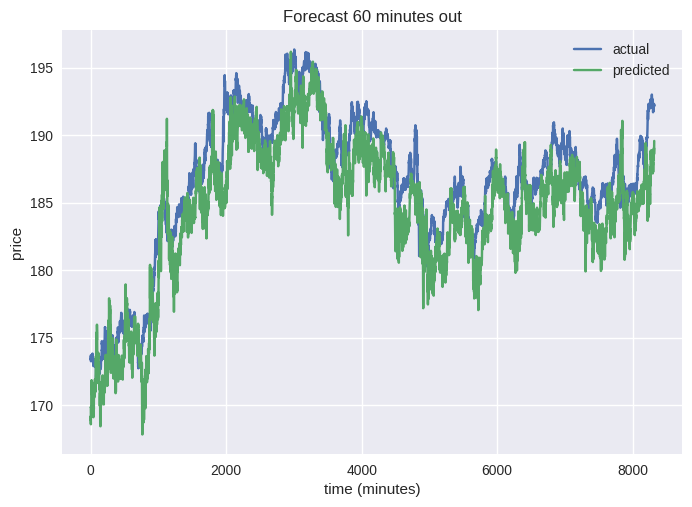

MSE:7.587151439091113


In [25]:
from sklearn.metrics import mean_squared_error

X_new = X_test_reshaped[:]
y_pred = model_BTC.predict(X_new) #we are predicting n-stepsahead now

plt.plot(y_test_btc, label="actual") #y_test is already the n-days out values
plt.plot(y_pred, label='predicted')
plt.xlabel('time (minutes)')
plt.ylabel('price')
plt.legend()
plt.title(f'Forecast {value_target} minutes out')
plt.show()

mse = mean_squared_error(y_test_btc, y_pred.ravel())
print(f'MSE:{mse}')

In [29]:
d = {'predicted':y_pred.ravel(), 'actual':y_test_btc}
new_df = pd.DataFrame(data=d)
new_df['difference'] = new_df['predicted']-new_df['actual']
new_df['difference'].mean()

-1.976785298721627

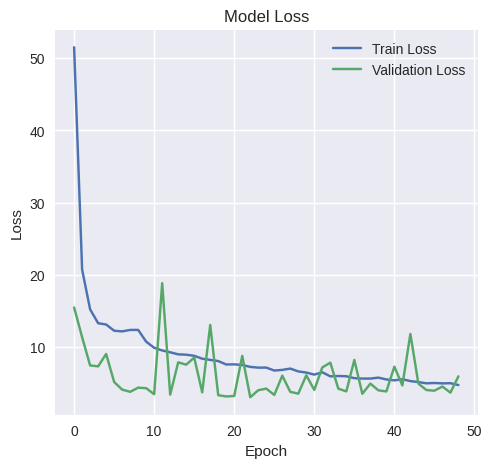

In [30]:
# Plotting the loss
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_BTC.history['loss'][1:], label='Train Loss')
plt.plot(history_BTC.history['val_loss'][1:], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [31]:
model_BTC.save("sol_model_intraday", save_format="tf")